# Cluster Aggregation

This tutorial shows how to aggregate clusterings across models/variables/etc.


In [ ]:
# Prerequisites
from toad import TOAD
from sklearn.cluster import HDBSCAN
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

/Users/jakobharteg/miniconda3/envs/toad312/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# start by initiating TOAD
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=2, y=2, GMST=2, boundary="trim").reduce(np.mean)
td.data = td.data.drop_vars(td.cluster_vars)

Compute some different clusterings, here using different time-scale factors


In [3]:
td.data = td.data.drop_vars(td.cluster_vars)
tsf_range = np.linspace(0.1, 10, 15)
for tsf in tsf_range:
    td.compute_clusters(
        shift_threshold=0.8, method=HDBSCAN(min_cluster_size=10), time_weight=tsf
    )

INFO: New cluster variable thk_dts_cluster: Identified 2 clusters in 2,510 pts; Left 0.9% as noise (22 pts).
INFO: New cluster variable thk_dts_cluster_1: Identified 11 clusters in 2,510 pts; Left 5.0% as noise (125 pts).
INFO: New cluster variable thk_dts_cluster_2: Identified 21 clusters in 2,510 pts; Left 10.9% as noise (274 pts).
INFO: New cluster variable thk_dts_cluster_3: Identified 22 clusters in 2,510 pts; Left 9.7% as noise (244 pts).
INFO: New cluster variable thk_dts_cluster_4: Identified 26 clusters in 2,510 pts; Left 14.2% as noise (356 pts).
INFO: New cluster variable thk_dts_cluster_5: Identified 26 clusters in 2,510 pts; Left 16.9% as noise (425 pts).
INFO: New cluster variable thk_dts_cluster_6: Identified 27 clusters in 2,510 pts; Left 14.7% as noise (370 pts).
INFO: New cluster variable thk_dts_cluster_7: Identified 25 clusters in 2,510 pts; Left 13.4% as noise (336 pts).
INFO: New cluster variable thk_dts_cluster_8: Identified 29 clusters in 2,510 pts; Left 15.6% a

Let's look at them


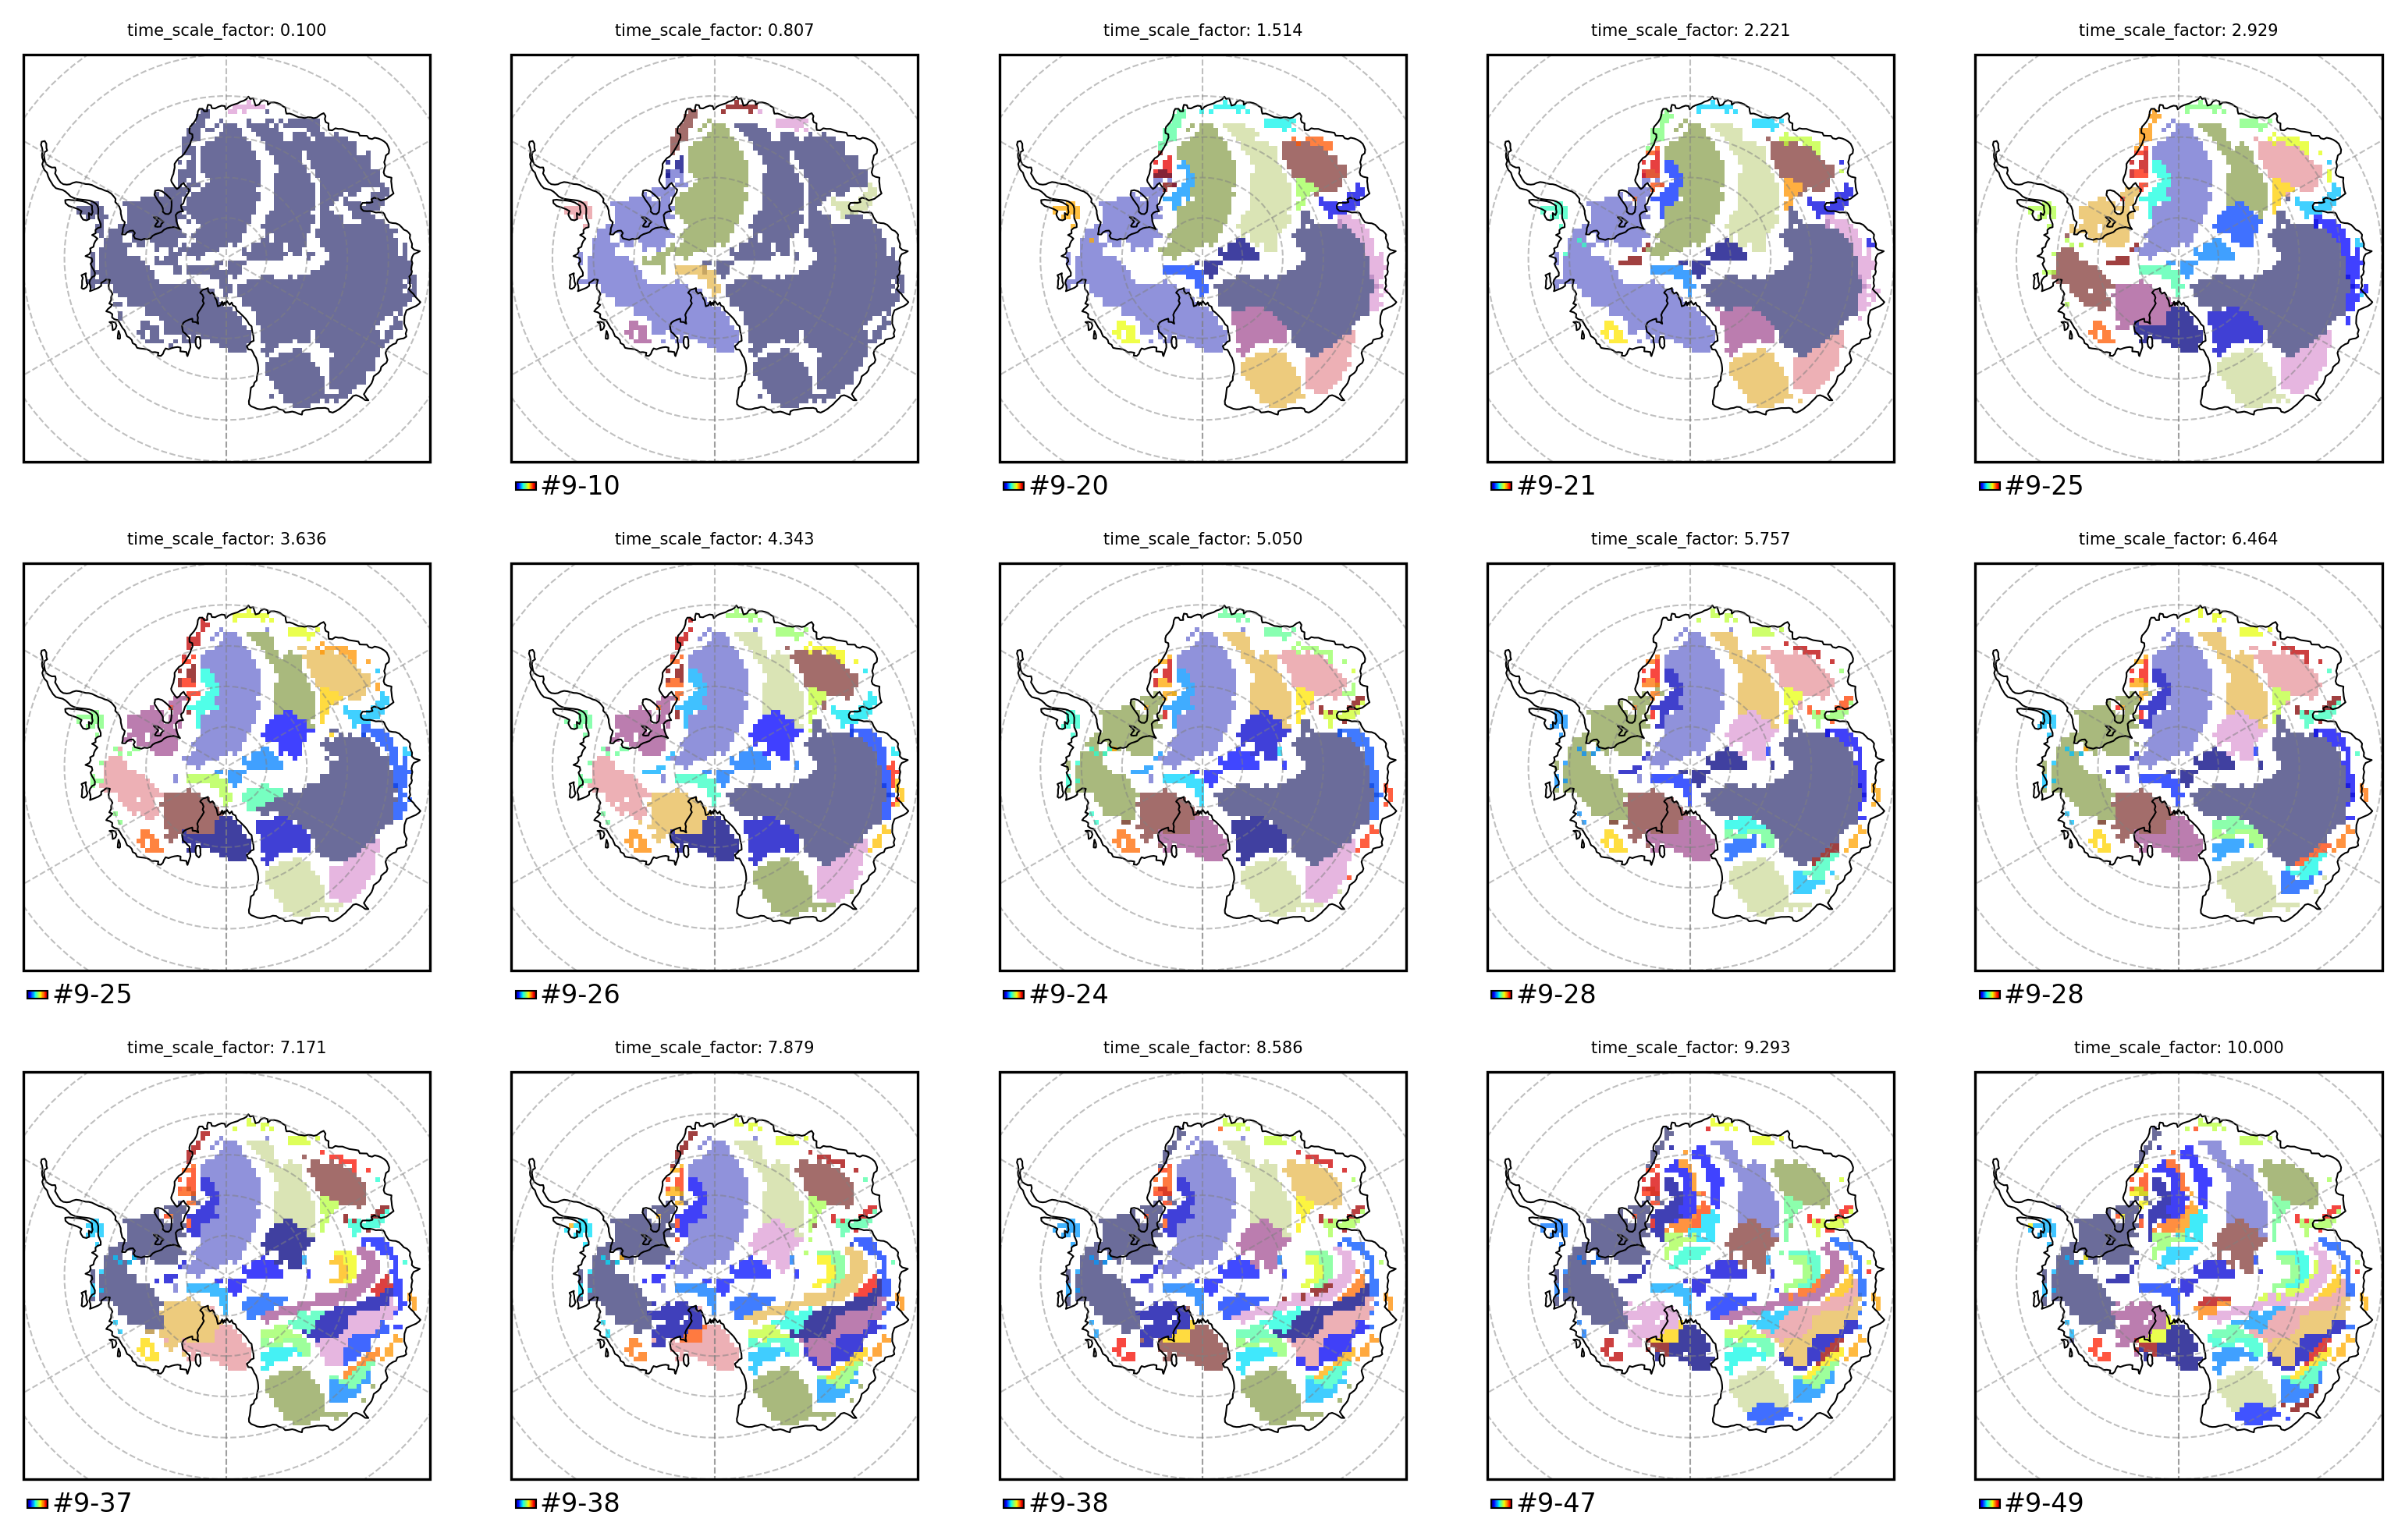

In [5]:
nrows = max(1, int(np.ceil(len(td.cluster_vars) / 5)))
fig, axs = td.plot.map(
    nrows, 5, figsize=(13, 8), map_style={"projection": "south_pole"}
)
axs = axs.flatten()
for index, cvar in enumerate(td.cluster_vars):
    td.plot.cluster_map(
        cvar,
        map_style={
            "projection": "south_pole",
            "plot_contour": False,
            "add_labels": False,
        },
        ax=axs[index],
    )
    axs[index].set_title(f"time_weight: {(tsf_range[index]):.3f}", fontsize=5)

Compute two examples of aggregation measures


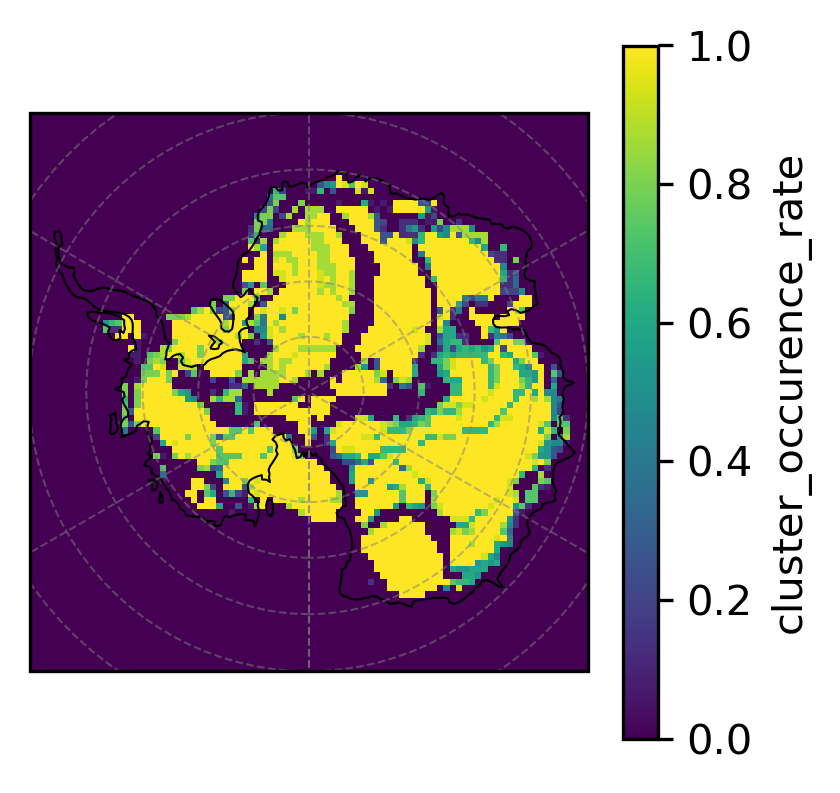

In [ ]:
hist = td.aggregate.cluster_occurrence_rate()
fig, ax = td.plot.map(1, 1, map_style={"projection": "south_pole"}, figsize=(3, 3))
hist.plot(ax=ax)  # type: ignore

In [11]:
ds_consensus, summary = td.aggregate.cluster_consensus()

In [ ]:
ds_consensus

<xarray.Dataset> Size: 110kB
Dimensions:      (x: 95, y: 95)
Coordinates:
  * x            (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y            (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
Data variables:
    clusters     (y, x) int64 72kB -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    consistency  (y, x) float32 36kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [14]:
summary.head()

,cluster_id,mean_consistency,size,mean_y,mean_x,mean_mean_shift_time,std_mean_shift_time,mean_std_shift_time,std_std_shift_time
0,0,0.921393,273,9.217582e+05,2.177289e+04,7.548415,0.000000e+00,0.277970,0.000000e+00
1,1,0.938463,256,1.397500e+05,-1.174000e+06,2.018538,4.440892e-16,0.161024,5.551115e-17
2,2,0.968760,199,-3.678794e+05,1.735759e+06,7.187788,0.000000e+00,0.619736,2.220446e-16
3,3,0.994020,125,1.195200e+06,8.624000e+05,9.485620,1.776357e-15,0.098788,2.775558e-17
4,4,0.987659,119,-1.680067e+06,9.815798e+05,3.838335,4.440892e-16,0.493108,5.551115e-17


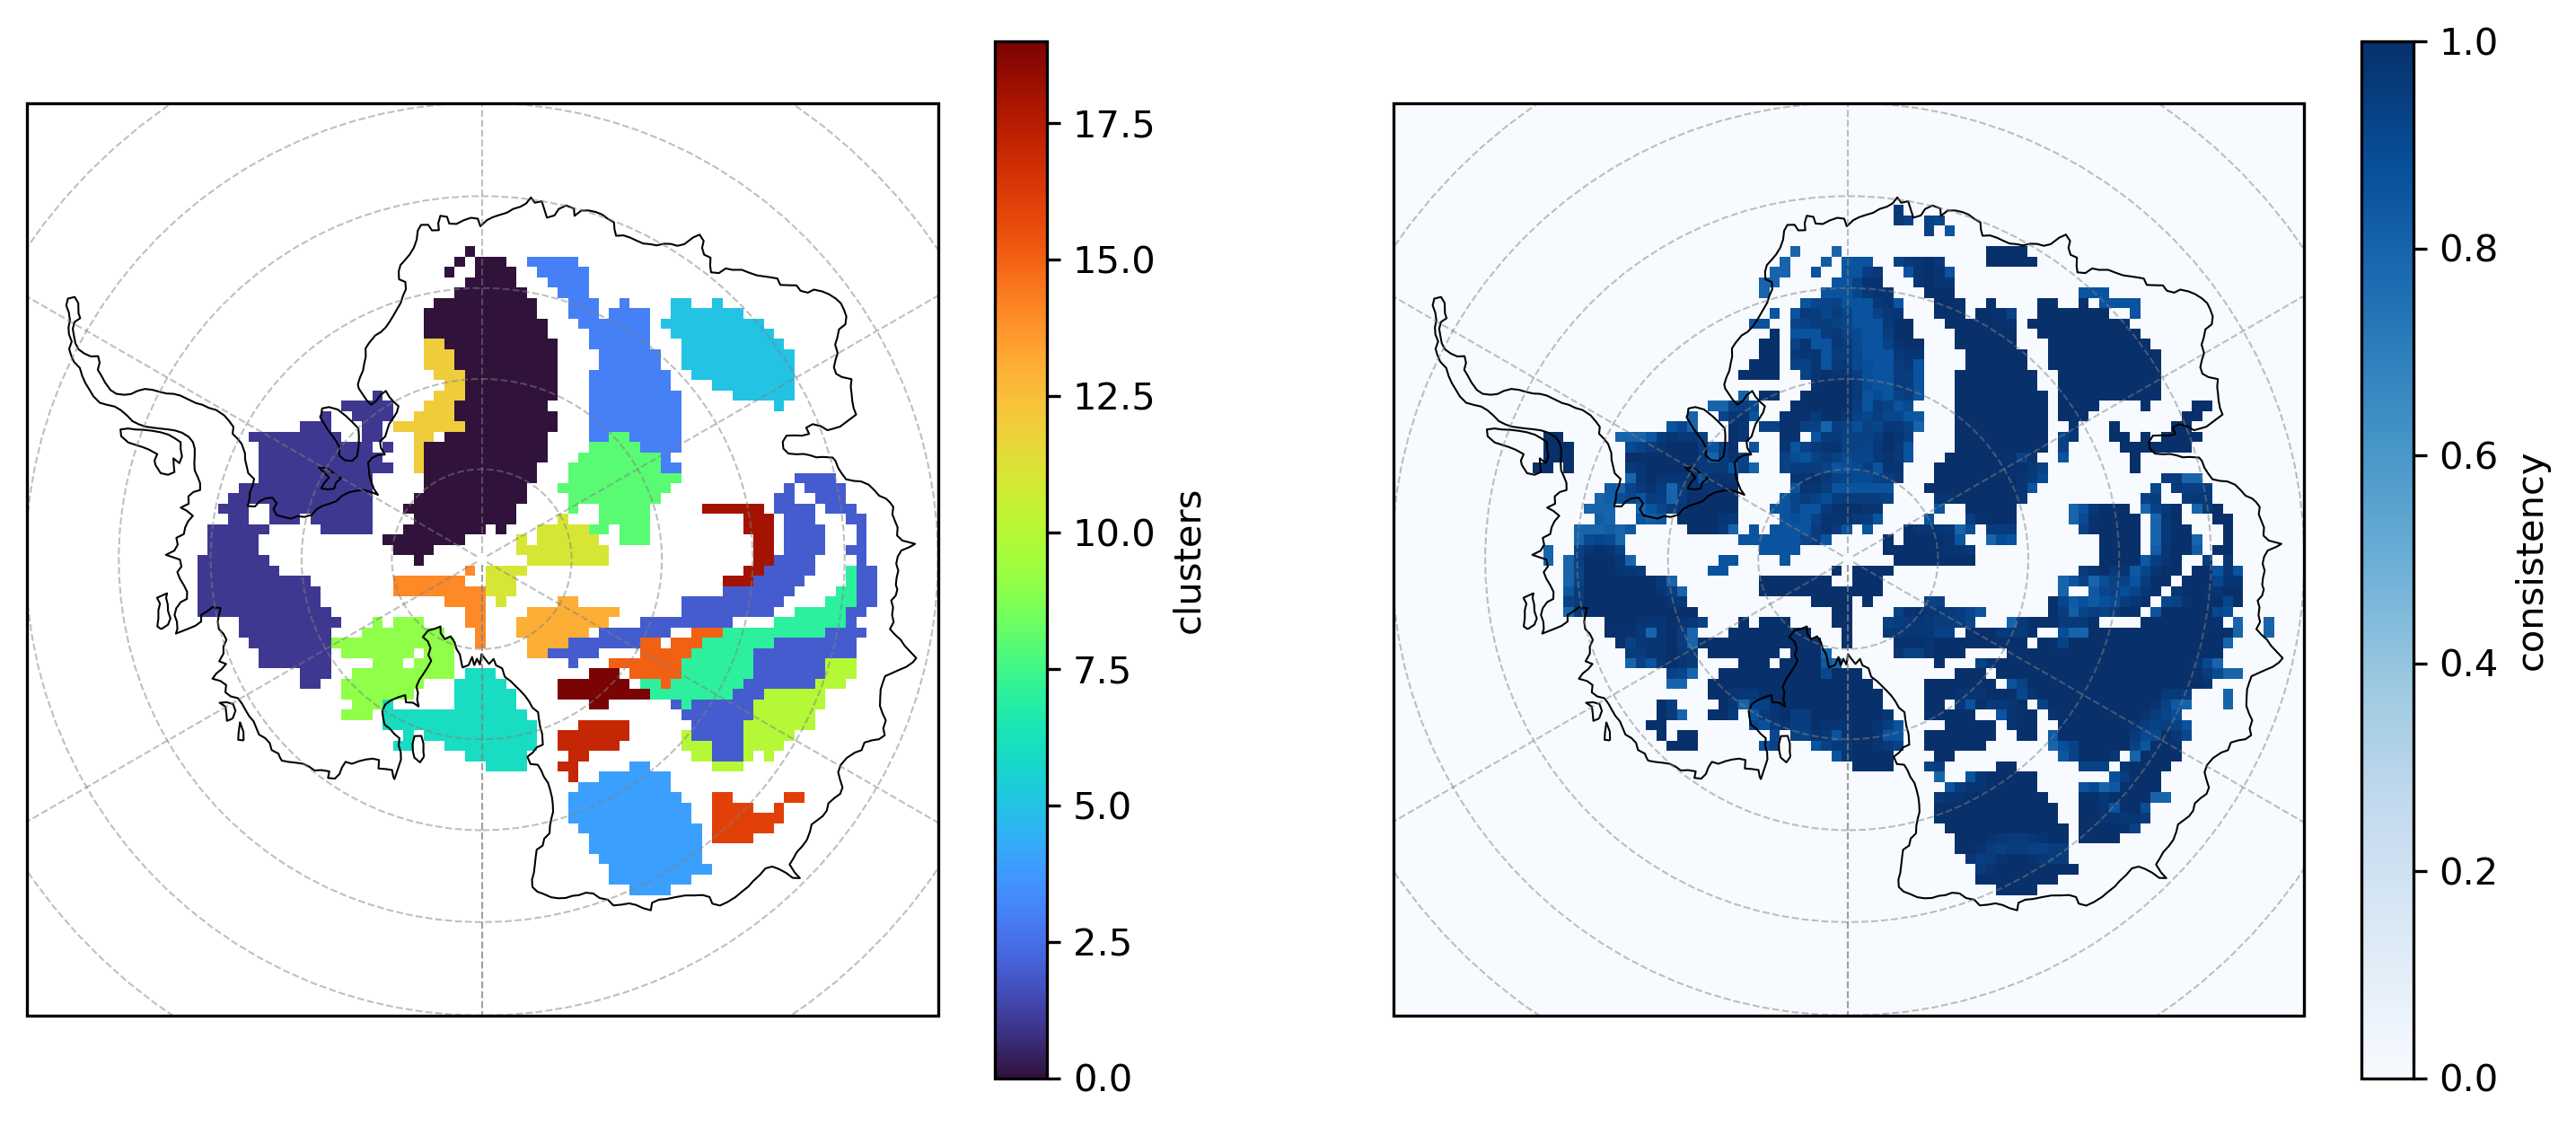

In [ ]:
fig, axs = td.plot.map(1, 2, map_style={"projection": "south_pole"})
ds_consensus.clusters.where(ds_consensus.clusters > -1).where(
    ds_consensus.clusters < 20
).plot(ax=axs[0], cmap="turbo")  # type: ignore
ds_consensus.consistency.plot(ax=axs[1], cmap="Blues")  # type: ignore
# axs[0].set_title("Cluster Consistency")
# axs[1].set_title("Cluster Occurrence Rate")